In [ ]:
import torch
from torch import nn # PyTorch building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.3.1+cu121'

# End to end workflow for pytorch

1. data, prepare and load
2. build model
3. fitting the model to data (training)
4. make predictions and evaluate model (inference)
5. saving and loading

1. Data, preparing and loadin

In [ ]:
# known parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(X[:10], "\n", y[:10])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) 
 tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


### Split data into training, validation, and testing sets

Always need training and testing for sure

In [ ]:
# Splitting our created data into training and testing sets
train_split = int(0.8 * len(X))

# split X and y into training and testing sets
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  # plot training data, test data
  plt.figure(figsize=(10, 7))

  # training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # plot predictions if exist
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})


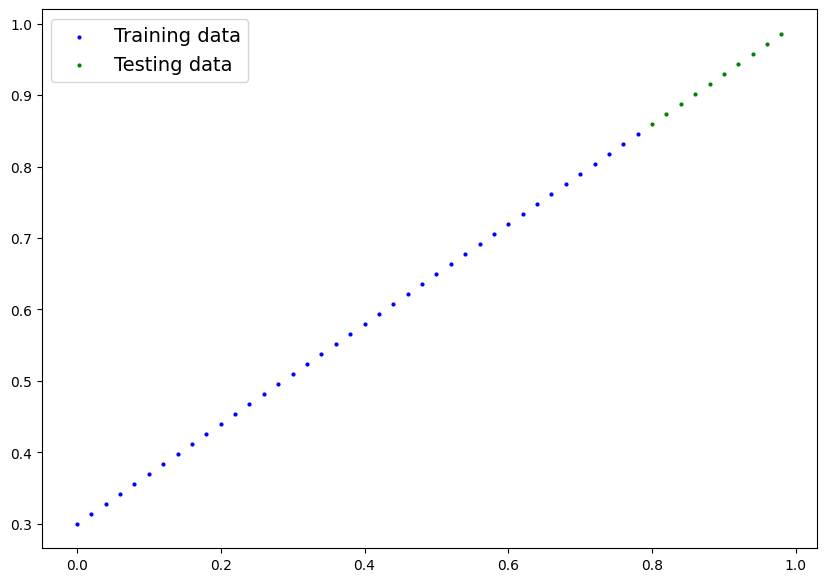

In [ ]:
plot_predictions()

### Build PyTorch model
Linear regression

Starts with random values for weight and bias

Looks at training data and adjusts the random values to better represent ideal values

Through two main:
1. Gradient descent https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html
Iteratively moves in the direction of steepest descent (negative of the gradient). Size of steps is called **learning rate**. Uses partial deriviatives using new *m* and *b *values. Uses results of backpropagation I think.
2. Backpropagation https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
adjust each weight in network **in proportion** to how much it contributes to overall error. Use chain rule to calculate derivative with respect to variables.
given Cost=C(R(Z(XW))), then C'(W)=C'(R)R'(Z)Z'(W)=(ŷ-y)R'(Z)X.

Number of calculations required to compute cost drivatives increases as network grows deeper (as just taking chain rule from last layer to first)

In [ ]:
from torch import nn
# linear regression model class

# inherit from nn.Module, base class for all neural network modules
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # gradient required
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # forward method to define computation in the model
  # you need to override this whens subclassing nn.Module
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias


### PyTorch model building essentials

a neural network can be considered a computational graph

torch.optim - where optimizers in PyTorch live, helps with gradient descent

def forward() - all nn.Module subclasses require this to be implemented, defines what happens next in forward computation

In [ ]:
# create a seed
torch.manual_seed(42)

# create an instance of model
model_0 = LinearRegressionModel()

# check parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

Making prediction using torch.inference_mode()

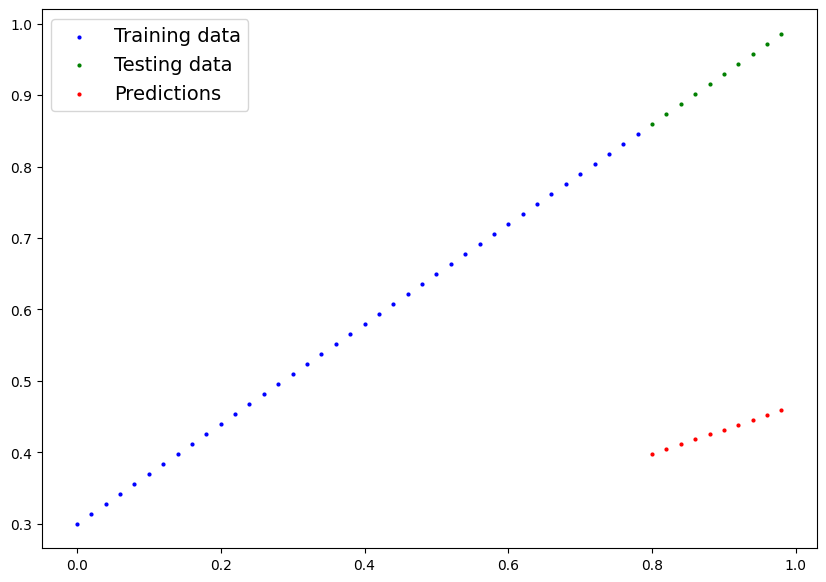

In [ ]:
# test our starting model
with torch.inference_mode():
  y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

# Train Model

Move from some unknown parameters to known parameters.

Measure how poor our model is using a loss function. Our optimizer will take into account the loss and adjust the model's parameters.

List of loss functions here: https://pytorch.org/docs/stable/nn.html#loss-functions

Optimizer functions: https://pytorch.org/docs/stable/optim.html

In [ ]:
# L1 loss is the mean absolute error
loss_fn = nn.L1Loss()

# setup optimizer. SGD is a popular one
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Build a training loop and test loop

1. Loop through data
2. Forward pass (data moving through model's forward function), or forward propagation
3. Calculate the loss, compare forward pass predictions to ground truth labels
4. Opimizer zero grad
5. Loss backward, move backward through network to calculate gradients of each parameter with respect to loss. *Gradients will be stored by tensors themselves when .backward() is called.*
6. Optimzer step, adjust parameters to try to improve loss. Will iterate over all parameters (tensors) and uses internally stored `grad` to update the values.


In [ ]:
# epoch is one lopp through the data
epochs = 100
epoch_count = []
loss_values = []
test_loss_values = []

torch.manual_seed(42)

# loop through data
for epoch in range(epochs):
  # set model to training mode
  model_0.train()

  # forward pass using forward() method
  y_pred = model_0(X_train)

  # calculate loss
  loss = loss_fn(y_pred, y_train)

  # zero the optimizer gradient
  optimizer.zero_grad()

  # backpropagation on loss. Gradients are stored by tensors once backward() is called
  loss.backward()

  # by default how the optimizer changes will accumulate through loop so we zero above
  optimizer.step()

  # testing
  model_0.eval()
  with torch.inference_mode():
    # do forward pass
    test_pred = model_0(X_test)
    # calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | TestLoss: {test_loss}")
    print(model_0.state_dict())


tensor(0.3129, grad_fn=<MeanBackward0>)
Epoch: 0 | Loss: 0.31288138031959534 | TestLoss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
tensor(0.3014, grad_fn=<MeanBackward0>)
tensor(0.2898, grad_fn=<MeanBackward0>)
tensor(0.2783, grad_fn=<MeanBackward0>)
tensor(0.2668, grad_fn=<MeanBackward0>)
tensor(0.2553, grad_fn=<MeanBackward0>)
tensor(0.2438, grad_fn=<MeanBackward0>)
tensor(0.2322, grad_fn=<MeanBackward0>)
tensor(0.2207, grad_fn=<MeanBackward0>)
tensor(0.2092, grad_fn=<MeanBackward0>)
tensor(0.1977, grad_fn=<MeanBackward0>)
Epoch: 10 | Loss: 0.1976713240146637 | TestLoss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
tensor(0.1862, grad_fn=<MeanBackward0>)
tensor(0.1746, grad_fn=<MeanBackward0>)
tensor(0.1631, grad_fn=<MeanBackward0>)
tensor(0.1516, grad_fn=<MeanBackward0>)
tensor(0.1401, grad_fn=<MeanBackward0>)
tensor(0.1285, grad_fn=<MeanBackward0>)
tensor(0.1170, grad_fn=<MeanBackward0

Graph the training and test loss curves

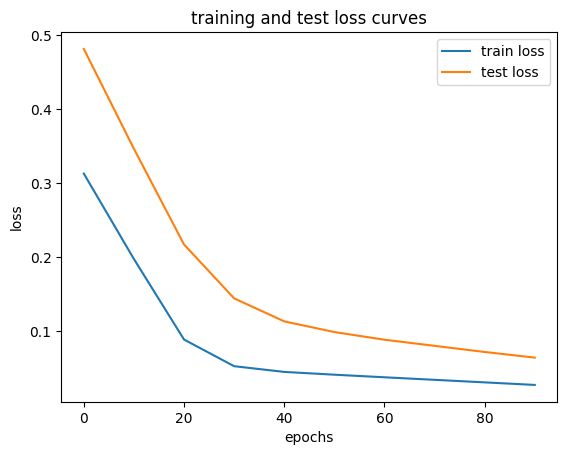

In [ ]:
import numpy as np

# graph the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="train loss")
plt.plot(epoch_count, test_loss_values, label="test loss")
plt.title("training and test loss curves")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

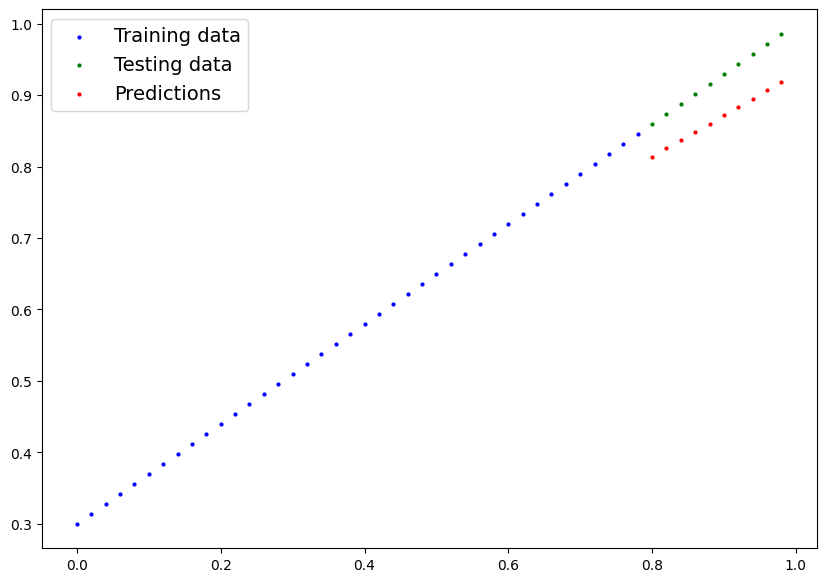

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

To avoid repeating training from scratch.

1. `torch.save()` - save object in Python pickel format
2. `torch.load()` - load saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - load model's saved state dictionary

A state dict is a dictionary object that maps each layer to its parameter tensor.

https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html


In [ ]:
# saving model
from pathlib import Path

# model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# save model state dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1680 Jul 23 23:25 01_pytorch_workflow_model_0.pth


# Extras
Practice loading the model we saved

In [ ]:
# instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# load the saved state_dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

print(loaded_model_0.state_dict(), "\n", model_0.state_dict())

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))]) 
 OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])


## Alternate way to implement LinearRegressionModel below,

Using nn.Linear()

Linear layer has weight matrix `W (nxm)` and bias vector `b (mx1)`. Given vector input `x` with shape `mx1`, output of linear lyaer is given `f(x)=Wx+b`, which is a vector of shape `nx1`. So `m` inputs and `n` outputs.

In [ ]:
class LinearRegressionModuleV2(nn.Module):
  def __init__(self):
    super().__init()
    # use nn.Linear() to initizlie parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_feature=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)
